# Proyek Klasifikasi Gambar: Garbage Classification (12 classes)
[Garbage Classification (12 classes)](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)
- **Nama:** Anggun Caksono
- **Email:** 78alrescha@gmail.com
- **ID Dicoding:** anggun_caksono_Gwjg

## Import Semua Packages/Library yang Digunakan

In [1]:
pip install tensorflow tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.5 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
plotnine 0.14.4 requires

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from PIL import Image, ImageOps
import tensorflowjs as tfjs

## Data Preparation

In [3]:
sdir=r'/kaggle/input/garbage-classification/garbage_classification'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /kaggle/input/garbage-classification/garbage_c...  metal
1  /kaggle/input/garbage-classification/garbage_c...  metal
2  /kaggle/input/garbage-classification/garbage_c...  metal
3  /kaggle/input/garbage-classification/garbage_c...  metal
4  /kaggle/input/garbage-classification/garbage_c...  metal
labels
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


### Data Loading

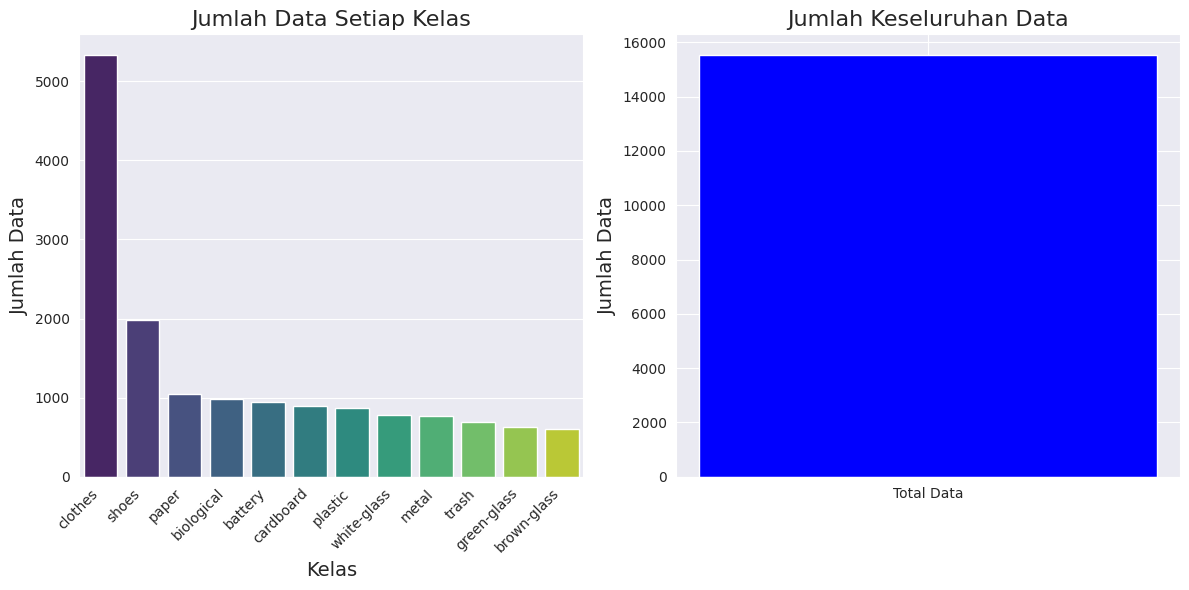

In [4]:
# Hitung jumlah sampel setiap kelas
class_counts = df['labels'].value_counts()
# Hitung total jumlah data
total_data = len(df)

plt.figure(figsize=(12, 6))

# Subplot 1: Jumlah Data Setiap Kelas
plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Jumlah Data Setiap Kelas', fontsize=16)
plt.xlabel('Kelas', fontsize=14)
plt.ylabel('Jumlah Data', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Subplot 2: Jumlah Keseluruhan Data
plt.subplot(1, 2, 2)
plt.bar('Total Data', total_data, color='blue')
plt.title('Jumlah Keseluruhan Data', fontsize=16)
plt.ylabel('Jumlah Data', fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
# Inisialisasi list untuk menyimpan ukuran gambar
widths = []
heights = []

# Loop melalui setiap file gambar
for filepath in df['filepaths']:
    with Image.open(filepath) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Tambahkan kolom 'width' dan 'height' ke DataFrame
df['width'] = widths
df['height'] = heights

# Cek DataFrame
print(df.head())

                                           filepaths labels  width  height
0  /kaggle/input/garbage-classification/garbage_c...  metal    512     384
1  /kaggle/input/garbage-classification/garbage_c...  metal    225     225
2  /kaggle/input/garbage-classification/garbage_c...  metal    512     384
3  /kaggle/input/garbage-classification/garbage_c...  metal    306     164
4  /kaggle/input/garbage-classification/garbage_c...  metal    512     384


In [6]:
# Hitung frekuensi pasangan lebar x tinggi
size_distribution = df.groupby(['width', 'height']).size().reset_index(name='count')

# Urutkan berdasarkan jumlah gambar (opsional)
size_distribution = size_distribution.sort_values(by='count', ascending=False)

# Tampilkan hasil
print(size_distribution)

     width  height  count
609    400     533   2590
824    512     384   2358
245    225     225   2004
610    400     534   1077
359    275     183    691
..     ...     ...    ...
36     155     325      1
37     155     326      1
39     156     324      1
40     157     322      1
41     158     318      1

[892 rows x 3 columns]


<ipython-input-7-e9f1efbfd272>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sizes['size'] = top_sizes['width'].astype(str) + ' x ' + top_sizes['height'].astype(str)


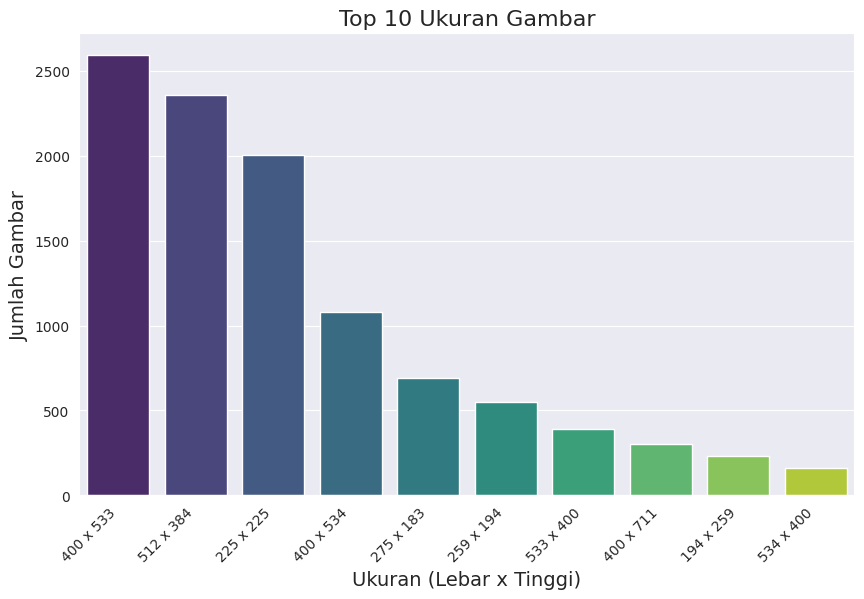

In [7]:
# Ambil 10 pasangan ukuran terbanyak untuk visualisasi
top_sizes = size_distribution.head(10)

# Gabungkan lebar dan tinggi menjadi satu label
top_sizes['size'] = top_sizes['width'].astype(str) + ' x ' + top_sizes['height'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='size', y='count', data=top_sizes, palette='viridis')
plt.title('Top 10 Ukuran Gambar', fontsize=16)
plt.xlabel('Ukuran (Lebar x Tinggi)', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

### Data Preprocessing

#### Split Dataset

In [8]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  12412   test_df length:  1551   valid_df length:  1552


In [9]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  47   test steps:  33
Found 12412 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [10]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

## Modelling

In [11]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [13]:
base_model.trainable = False

In [14]:
model_name='xception'
print("Building model with", base_model)
model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(12, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <Functional name=xception, built=True>


In [15]:
epochs =20

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 111s 431ms/step - accuracy: 0.6714 - loss: 1.0657 - val_accuracy: 0.8866 - val_loss: 0.3638
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 313ms/step - accuracy: 0.8708 - loss: 0.4003 - val_accuracy: 0.9072 - val_loss: 0.3016
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 63s 315ms/step - accuracy: 0.9061 - loss: 0.2866 - val_accuracy: 0.8988 - val_loss: 0.3216
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 314ms/step - accuracy: 0.9295 - loss: 0.2197 - val_accuracy: 0.9104 - val_loss: 0.3158
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 311ms/step - accuracy: 0.9355 - loss: 0.1918 - val_accuracy: 0.9259 - val_loss: 0.3029
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 314ms/step - accuracy: 0.9517 - loss: 0.1476 - val_accuracy: 0.9201 - val_loss: 0.2866
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 314ms/step - accuracy: 0.9584 - loss: 0.1240 - val_accuracy: 0.9233 - val_loss: 0.2978
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 314ms/step - accuracy: 0.9585 - loss: 0.1175 - va

## Evaluasi dan Visualisasi

In [16]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [17]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

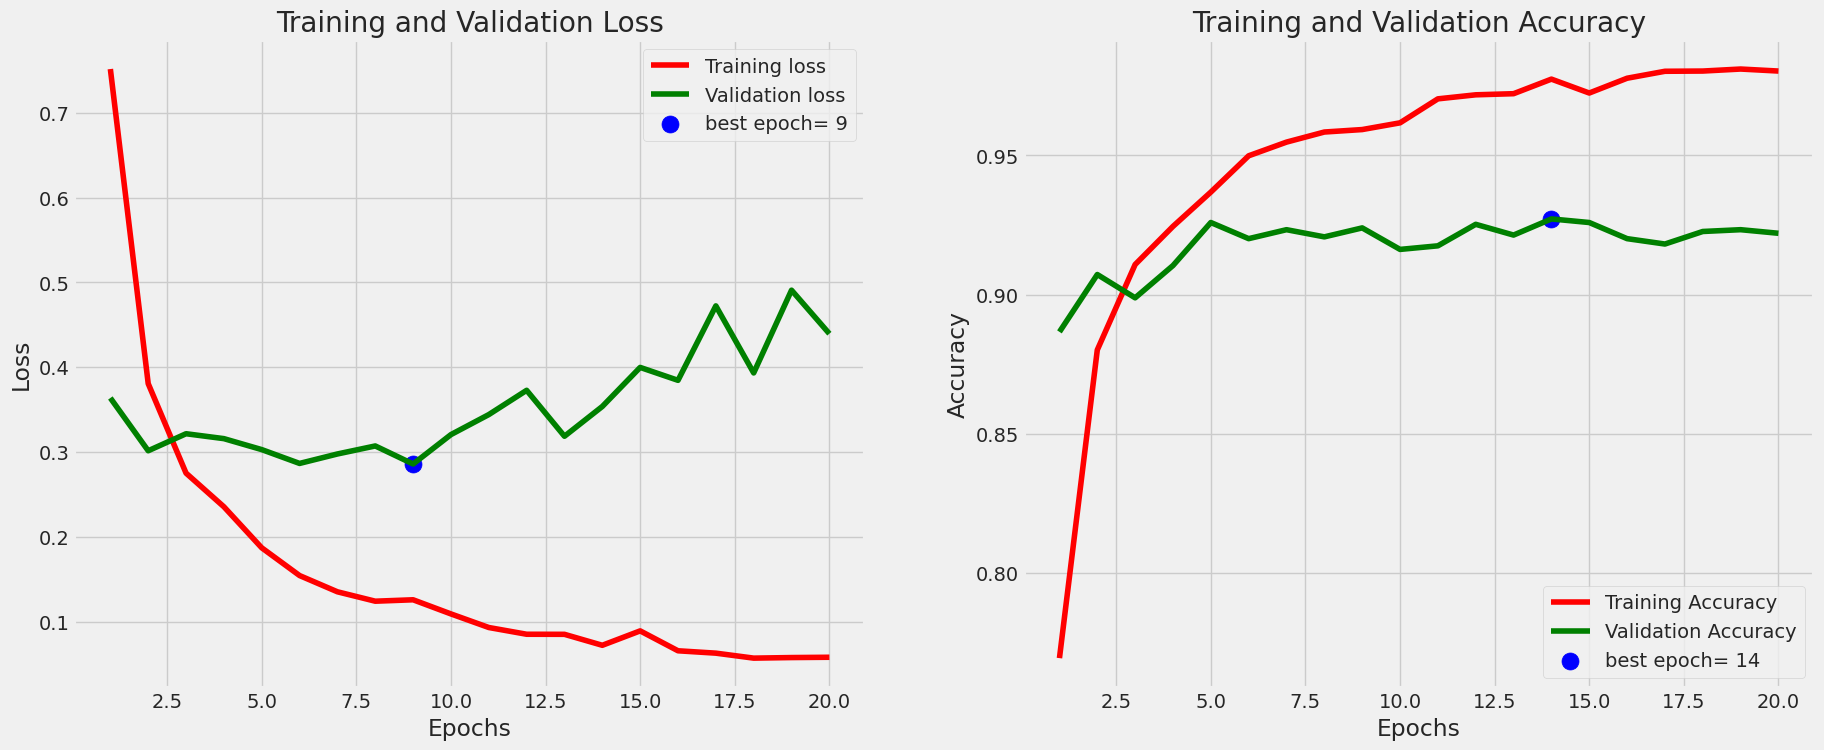

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step - accuracy: 0.9320 - loss: 0.4971
accuracy on the test set is 92.52 %



In [18]:
tr_plot(history,0)
save_dir=r'./model'
subject='klasifikasi-sampah'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [19]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step


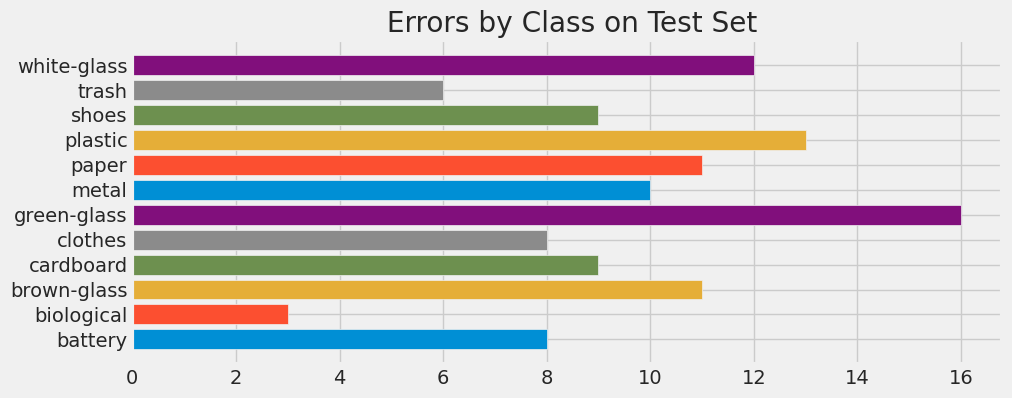

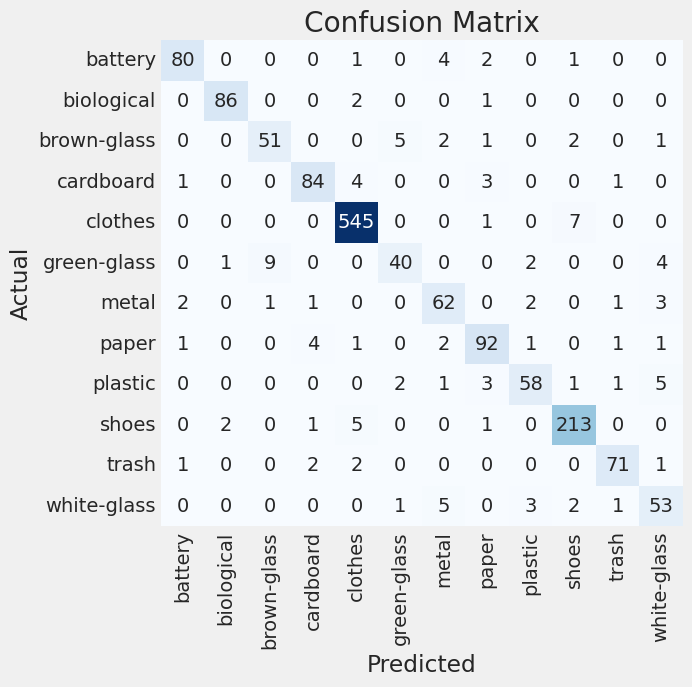

Classification Report:
----------------------
               precision    recall  f1-score   support

     battery       0.94      0.91      0.92        88
  biological       0.97      0.97      0.97        89
 brown-glass       0.84      0.82      0.83        62
   cardboard       0.91      0.90      0.91        93
     clothes       0.97      0.99      0.98       553
 green-glass       0.83      0.71      0.77        56
       metal       0.82      0.86      0.84        72
       paper       0.88      0.89      0.89       103
     plastic       0.88      0.82      0.85        71
       shoes       0.94      0.96      0.95       222
       trash       0.93      0.92      0.93        77
 white-glass       0.78      0.82      0.80        65

    accuracy                           0.93      1551
   macro avg       0.89      0.88      0.89      1551
weighted avg       0.92      0.93      0.92      1551



In [20]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

## Konversi Model

In [21]:
# Direktori untuk menyimpan model
save_dir = './model'
subject = 'klasifikasi-sampah'

# Evaluasi model pada test set
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
# Simpan model dalam format SavedModel
saved_model_dir = os.path.join(save_dir, 'saved_model')
tf.saved_model.save(model, saved_model_dir)  # Gunakan tf.saved_model.save
print(f"Model disimpan dalam format SavedModel di: {saved_model_dir}")

# Simpan model dalam format TF-Lite (tanpa optimasi)
tflite_model_dir = os.path.join(save_dir, 'model.tflite')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_dir, 'wb') as f:
    f.write(tflite_model)
print(f"Model disimpan dalam format TF-Lite (tanpa optimasi) di: {tflite_model_dir}")

# Simpan model dalam format TF-Lite dengan optimasi
tflite_optimized_model_dir = os.path.join(save_dir, 'model_optimized.tflite')

# Opsi optimasi
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimasi untuk ukuran dan performa

# Konversi model dengan optimasi
tflite_optimized_model = converter.convert()

# Simpan model TF-Lite yang dioptimasi
with open(tflite_optimized_model_dir, 'wb') as f:
    f.write(tflite_optimized_model)
print(f"Model disimpan dalam format TF-Lite (dengan optimasi) di: {tflite_optimized_model_dir}")

# Simpan model dalam format TFJS
tfjs_model_dir = os.path.join(save_dir, 'tfjs_model')
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model disimpan dalam format TFJS di: {tfjs_model_dir}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.9320 - loss: 0.4971
Model disimpan dalam format SavedModel di: ./model/saved_model
Saved artifact at '/tmp/tmpnt9mczo5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  138166610503888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610500896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610504416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610503536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610505120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610509344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610742432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138166610739968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13816661074

## Inference (Optional)

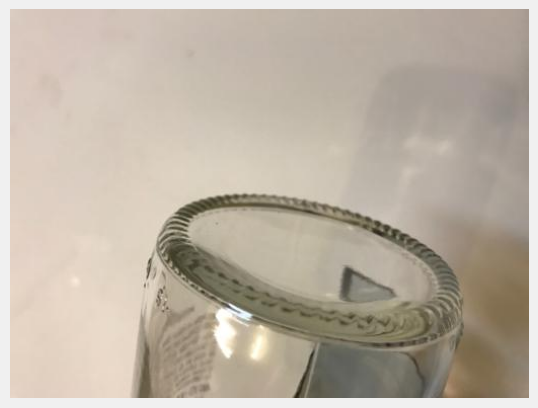

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: white-glass (76.59%)
Probability: 
battery: 0.00%
Probability: 
biological: 0.00%
Probability: 
brown-glass: 0.00%
Probability: 
cardboard: 0.00%
Probability: 
clothes: 0.00%
Probability: 
green-glass: 0.00%
Probability: 
metal: 0.00%
Probability: 
paper: 0.00%
Probability: 
plastic: 0.00%
Probability: 
shoes: 0.02%
Probability: 
trash: 23.38%
Probability: 
white-glass: 76.59%


In [28]:
# Load the class labels
class_labels = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}

# Load image from your computer
img_path = '/kaggle/input/garbage-classification/garbage_classification/white-glass/white-glass102.jpg'
image = Image.open(img_path)

# Convert image to RGB if it has an alpha channel (RGBA)
if image.mode == 'RGBA':
    image = image.convert('RGB')

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess the image: resize and normalize
image = ImageOps.fit(image, (224, 224))  # Resize to 224x224, adjust as needed
image_array = np.array(image) / 255.0  # Normalize to [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Load model
model = tf.keras.models.load_model('/kaggle/working/model/xception-klasifikasi-sampah-92.52.h5')

# Predict using the model
prediction = model.predict(image_array)[0]

# Calculate the predicted class and percentage
predicted_class_index = np.argmax(prediction)
predicted_class = class_labels[predicted_class_index]
predicted_percentage = prediction[predicted_class_index] * 100

# Display the prediction results with percentages
print(f"Predicted class: {predicted_class} ({predicted_percentage:.2f}%)")

# Display all class probabilities
for i, prob in enumerate(prediction):
    print("Probability: ")
    print(f"{class_labels[i]}: {prob * 100:.2f}%")
